In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn import linear_model

pd.set_option('max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
data = pd.ExcelFile('booking_clean_v3.xlsx')
data = data.parse(sheet_name = 'Sheet1')

In [3]:
data.shape

(1000, 102)

In [4]:
data = data.drop(['Unnamed: 0'], axis=1)
data.head(5)

,name,city_new,room_classification,free_breakfast,free_cancellation,review,star_rating,price_per_day,preferred_partner_property,city_population,lat,lon,tourist_attraction,point_of_interest,establishment,museum,city_hall,local_government_office,book_store,store,park,art_gallery,church,place_of_worship,school,airport,night_club,bakery,bar,restaurant,food,lodging,meal_takeaway,cafe,meal_delivery,beauty_salon,spa,gym,health,doctor,hair_care,hospital,travel_agency,atm,finance,grocery_or_supermarket,pharmacy,supermarket,taxi_stand,physiotherapist,liquor_store,synagogue,premise,home_goods_store,parking,shopping_mall,department_store,movie_theater,shoe_store,clothing_store,veterinary_care,electronics_store,bowling_alley,hindu_temple,real_estate_agency,casino,convenience_store,gas_station,general_contractor,university,natural_feature,amusement_park,car_wash,jewelry_store,bicycle_store,movie_rental,dentist,drugstore,storage,pet_store,cemetery,moving_company,library,zoo,mosque,aquarium,car_rental,hardware_store,campground,stadium,fire_station,laundry,car_repair,bus_station,transit_station,florist,rv_park,car_dealer,primary_school,courthouse,furniture_store
0,GreenTree Pasadena,Pasadena,King Room,1,0,1586,3,165.25,1,12750807,34.138934,-118.146914,20,76,76,8,1,1,1,5,6,1,1,1,2,3,14,3,21,26,26,1,3,1,1,12,20,1,16,8,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Big Bear Inn,Big Bear Lake,King Room,0,0,720,2,113.62,0,12750807,34.243504,-116.915642,20,55,55,0,0,0,0,3,6,0,2,2,0,0,6,0,10,23,23,1,3,2,1,2,10,0,4,0,3,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Red Lion Inn & Suites Auburn,Auburn,King Room,1,0,667,3,100.38,1,3592294,38.898076,-121.071247,19,61,61,4,0,0,0,7,7,0,0,0,0,0,2,1,4,20,21,0,2,5,1,10,20,1,8,0,4,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Regency Inn in Los Angeles,Los Angeles,King Room,0,0,313,2,121.88,1,12750807,34.139681,-118.218387,5,49,49,0,0,0,0,0,5,0,0,0,0,1,4,0,7,22,22,0,6,0,2,8,20,0,10,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Hotel La Rose,Santa Rosa,Other,0,1,634,3,205.25,0,37708,38.437927,-122.720924,20,69,69,2,0,0,0,2,10,0,1,1,0,2,7,0,9,21,21,0,6,0,3,6,20,1,13,2,3,0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
#print(data.columns.tolist())

In [6]:
#data.describe()

<AxesSubplot:xlabel='price_per_day', ylabel='Density'>

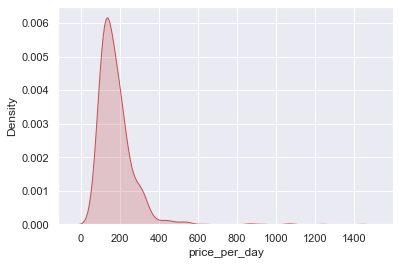

In [7]:
sns.set(style="darkgrid")

sns.kdeplot(data['price_per_day'], shade=True, color="r")

Most of the hotel prices are less than 400 USD per day.

<AxesSubplot:xlabel='star_rating', ylabel='price_per_day'>

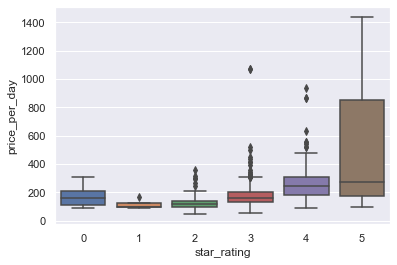

In [8]:
sns.boxplot(x=data["star_rating"], y=data["price_per_day"])

Price of star rating with 5 has the highest range and the median is higher too, which is natural to observe. 

<AxesSubplot:xlabel='review', ylabel='price_per_day'>

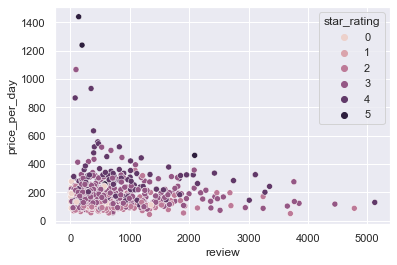

In [9]:
sns.scatterplot(
    data=data, x="review", y="price_per_day", 
    hue="star_rating",
    sizes=(20, 200), legend="full")

<AxesSubplot:xlabel='star_rating', ylabel='review'>

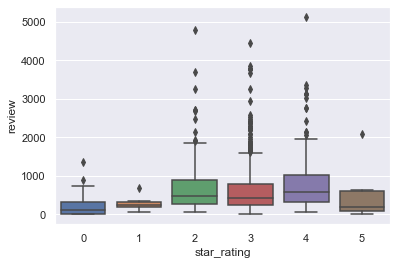

In [10]:
sns.boxplot(x=data["star_rating"], y=data["review"])

Most of the reviews are for star rating 2,3 & 4. 

<AxesSubplot:xlabel='room_classification', ylabel='price_per_day'>

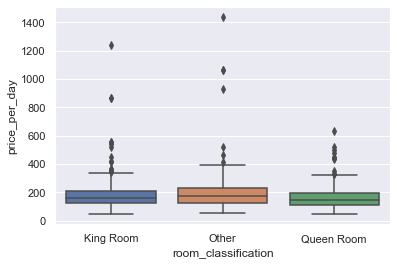

In [11]:
sns.boxplot(x=data["room_classification"], y=data["price_per_day"])

Room Classification doesn't have much of an influence. <br> <b> What does 'Other' mean here? 

<AxesSubplot:xlabel='free_breakfast', ylabel='price_per_day'>

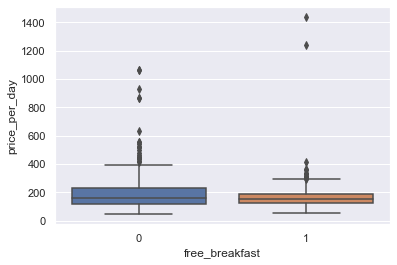

In [12]:
sns.boxplot(x=data["free_breakfast"], y=data["price_per_day"])

Hotels with no 'free breakfast' tend to have higher prices, based on the sample set even though there are couple of outliers suggesting otherwise.

<AxesSubplot:xlabel='free_cancellation', ylabel='price_per_day'>

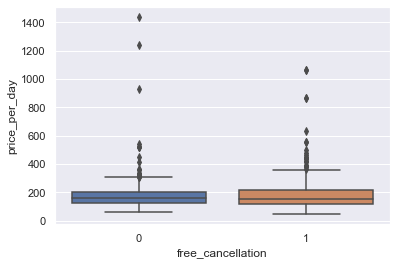

In [13]:
sns.boxplot(x=data["free_cancellation"], y=data["price_per_day"])

Not much difference based on cancellation policy.

<AxesSubplot:xlabel='review', ylabel='price_per_day'>

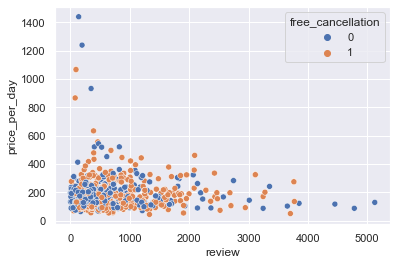

In [14]:
sns.scatterplot(
    data=data, x="review", y="price_per_day", 
    hue="free_cancellation",
    sizes=(20, 200), legend="full")

<AxesSubplot:xlabel='city_population', ylabel='price_per_day'>

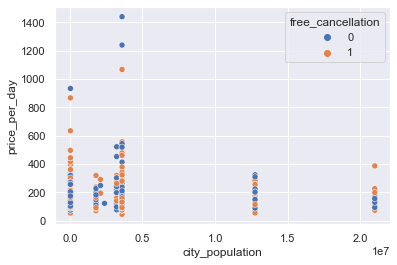

In [15]:
sns.scatterplot(
    data=data, x="city_population", y="price_per_day", 
    hue="free_cancellation",
    sizes=(20, 200), legend="full")

<b> How is the population defined? 

<AxesSubplot:xlabel='preferred_partner_property', ylabel='price_per_day'>

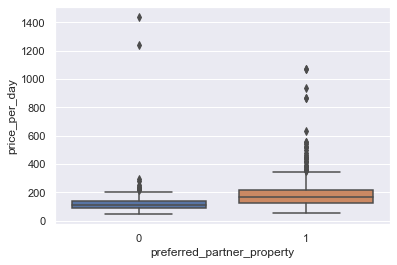

In [16]:
sns.boxplot( x=data["preferred_partner_property"], y=data["price_per_day"])

Preferred partner properties have higher variation. <b> Why?

#### Pre-processing

No NULL values in the dataset. So we need to standardise the numerical columns, for prediction purposes.

In [17]:
corr_df = pd.DataFrame(data.corr()['price_per_day'].sort_values(ascending=False))
corr_df.reset_index(inplace = True)

In [18]:
corr_df.columns = ['variable','corr']

In [19]:
#corr_df

In [20]:
# Absolute the correlation and remove the price column
corr_df['abs_corr'] = np.abs(corr_df['corr'])
corr_df = corr_df.drop([0], axis=0)

In [21]:
corr_df

,variable,corr,abs_corr
1,star_rating,0.361114,0.361114
2,bar,0.273340,0.273340
3,tourist_attraction,0.252633,0.252633
4,lodging,0.234878,0.234878
5,food,0.224674,0.224674
6,night_club,0.208039,0.208039
7,health,0.197547,0.197547
8,art_gallery,0.195132,0.195132
9,doctor,0.191127,0.191127
10,establishment,0.186436,0.186436


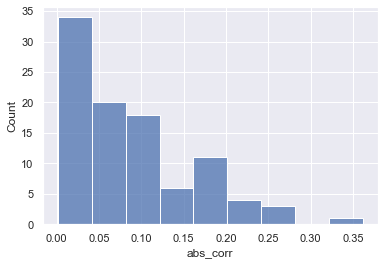

In [22]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
sns.histplot(data=corr_df, x="abs_corr")
plt.show()

In order to choose few variables for our benchmark model, we can use variables that has absolute correlation over 0.1

In [23]:
var_selected_lm = corr_df[(corr_df['abs_corr']>0.1)]['variable']

In [24]:
len(var_selected_lm)

31

In [25]:
X1 = data[list(var_selected_lm)]
y1 = data['price_per_day']

In [26]:
# Convert the categorical variables to include dummies
if 'room_classification' in list(var_selected_lm):
    X = pd.get_dummies(X1, columns=['room_classification'], drop_first=True)

In [27]:
X1.head(5)

,star_rating,bar,tourist_attraction,lodging,food,night_club,health,art_gallery,doctor,establishment,point_of_interest,museum,liquor_store,general_contractor,bicycle_store,campground,restaurant,parking,church,beauty_salon,hair_care,place_of_worship,premise,preferred_partner_property,clothing_store,local_government_office,shopping_mall,spa,free_breakfast,meal_delivery,meal_takeaway
0,3,21,20,1,26,14,16,1,8,76,76,8,0,0,0,0,26,0,1,12,9,1,0,1,0,1,0,20,1,1,3
1,2,10,20,1,23,6,4,0,0,55,55,0,0,0,0,0,23,0,2,2,3,2,0,0,0,0,0,10,0,1,3
2,3,4,19,0,21,2,8,0,0,61,61,4,0,0,0,0,20,0,0,10,4,0,0,1,0,0,0,20,1,1,2
3,2,7,5,0,22,4,10,0,2,49,49,0,0,0,0,0,22,0,0,8,5,0,0,1,0,0,0,20,0,2,6
4,3,9,20,0,21,7,13,0,2,69,69,2,0,0,0,0,21,0,1,6,3,1,0,0,0,0,0,20,0,3,6


In [28]:
# Standardise the dataset
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)

In [29]:
#X_scaled

In [30]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1_scaled, y1, train_size=0.8, random_state=100)

## Model Building

### Linear model on the standardised dataset

In [31]:
# build a basic linear regression model
lm = LinearRegression()
lm.fit(X_train1, y_train1)

LinearRegression()

In [32]:
lm_y_pred_in = lm.predict(X_train1)
r2_score(y_train1, lm_y_pred_in)

0.4436661230337934

In [33]:
lm_y_pred_out = lm.predict(X_test1)
r2_score(y_test1, lm_y_pred_out)

0.09587146747975739

The out of sample R-squared is about 10% while the in-sample R-squared is 44%. <br> <br>

<b> This can be our benchmark model. Let's use this to improve our model. </b>

### Lasso Regression

In [34]:
data.head(5)

,name,city_new,room_classification,free_breakfast,free_cancellation,review,star_rating,price_per_day,preferred_partner_property,city_population,lat,lon,tourist_attraction,point_of_interest,establishment,museum,city_hall,local_government_office,book_store,store,park,art_gallery,church,place_of_worship,school,airport,night_club,bakery,bar,restaurant,food,lodging,meal_takeaway,cafe,meal_delivery,beauty_salon,spa,gym,health,doctor,hair_care,hospital,travel_agency,atm,finance,grocery_or_supermarket,pharmacy,supermarket,taxi_stand,physiotherapist,liquor_store,synagogue,premise,home_goods_store,parking,shopping_mall,department_store,movie_theater,shoe_store,clothing_store,veterinary_care,electronics_store,bowling_alley,hindu_temple,real_estate_agency,casino,convenience_store,gas_station,general_contractor,university,natural_feature,amusement_park,car_wash,jewelry_store,bicycle_store,movie_rental,dentist,drugstore,storage,pet_store,cemetery,moving_company,library,zoo,mosque,aquarium,car_rental,hardware_store,campground,stadium,fire_station,laundry,car_repair,bus_station,transit_station,florist,rv_park,car_dealer,primary_school,courthouse,furniture_store
0,GreenTree Pasadena,Pasadena,King Room,1,0,1586,3,165.25,1,12750807,34.138934,-118.146914,20,76,76,8,1,1,1,5,6,1,1,1,2,3,14,3,21,26,26,1,3,1,1,12,20,1,16,8,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Big Bear Inn,Big Bear Lake,King Room,0,0,720,2,113.62,0,12750807,34.243504,-116.915642,20,55,55,0,0,0,0,3,6,0,2,2,0,0,6,0,10,23,23,1,3,2,1,2,10,0,4,0,3,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Red Lion Inn & Suites Auburn,Auburn,King Room,1,0,667,3,100.38,1,3592294,38.898076,-121.071247,19,61,61,4,0,0,0,7,7,0,0,0,0,0,2,1,4,20,21,0,2,5,1,10,20,1,8,0,4,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Regency Inn in Los Angeles,Los Angeles,King Room,0,0,313,2,121.88,1,12750807,34.139681,-118.218387,5,49,49,0,0,0,0,0,5,0,0,0,0,1,4,0,7,22,22,0,6,0,2,8,20,0,10,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Hotel La Rose,Santa Rosa,Other,0,1,634,3,205.25,0,37708,38.437927,-122.720924,20,69,69,2,0,0,0,2,10,0,1,1,0,2,7,0,9,21,21,0,6,0,3,6,20,1,13,2,3,0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
X2 = data.drop(['name','city_new','price_per_day','lat','lon'],axis=1)
y2 = data['price_per_day']

In [36]:
# Convert the categorical variables to include dummies
X2 = pd.get_dummies(X2, columns=['room_classification'], drop_first=True)

In [37]:
# Standardise the dataset
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)

In [38]:
X2.head(5)

,free_breakfast,free_cancellation,review,star_rating,preferred_partner_property,city_population,tourist_attraction,point_of_interest,establishment,museum,city_hall,local_government_office,book_store,store,park,art_gallery,church,place_of_worship,school,airport,night_club,bakery,bar,restaurant,food,lodging,meal_takeaway,cafe,meal_delivery,beauty_salon,spa,gym,health,doctor,hair_care,hospital,travel_agency,atm,finance,grocery_or_supermarket,pharmacy,supermarket,taxi_stand,physiotherapist,liquor_store,synagogue,premise,home_goods_store,parking,shopping_mall,department_store,movie_theater,shoe_store,clothing_store,veterinary_care,electronics_store,bowling_alley,hindu_temple,real_estate_agency,casino,convenience_store,gas_station,general_contractor,university,natural_feature,amusement_park,car_wash,jewelry_store,bicycle_store,movie_rental,dentist,drugstore,storage,pet_store,cemetery,moving_company,library,zoo,mosque,aquarium,car_rental,hardware_store,campground,stadium,fire_station,laundry,car_repair,bus_station,transit_station,florist,rv_park,car_dealer,primary_school,courthouse,furniture_store,room_classification_Other,room_classification_Queen Room
0,1,0,1586,3,1,12750807,20,76,76,8,1,1,1,5,6,1,1,1,2,3,14,3,21,26,26,1,3,1,1,12,20,1,16,8,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,720,2,0,12750807,20,55,55,0,0,0,0,3,6,0,2,2,0,0,6,0,10,23,23,1,3,2,1,2,10,0,4,0,3,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,667,3,1,3592294,19,61,61,4,0,0,0,7,7,0,0,0,0,0,2,1,4,20,21,0,2,5,1,10,20,1,8,0,4,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,313,2,1,12750807,5,49,49,0,0,0,0,0,5,0,0,0,0,1,4,0,7,22,22,0,6,0,2,8,20,0,10,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,634,3,0,37708,20,69,69,2,0,0,0,2,10,0,1,1,0,2,7,0,9,21,21,0,6,0,3,6,20,1,13,2,3,0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [39]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2_scaled, y2, train_size=0.8, random_state=80)

In [40]:
# Fitting a lasso regressor
lasso_lars_ic1 = make_pipeline(
    StandardScaler(), LassoLarsIC(criterion="aic", normalize=False)
).fit(X_train2, y_train2)

/Users/joaopedro/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 51 iterations, i.e. alpha=1.780e+00, with an active set of 49 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/joaopedro/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 62 iterations, alpha=1.366e+00, previous alpha=1.366e+00, with an active set of 59 regressors.
  warnings.warn(


In [41]:
# iterating over different alpha and reporting the AIC
results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic1[-1].alphas_,
        "AIC criterion": lasso_lars_ic1[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic1[-1].alpha_

In [42]:
# same for BIC
lasso_lars_ic1.set_params(lassolarsic__criterion="bic").fit(X_train2, y_train2)
results["BIC criterion"] = lasso_lars_ic1[-1].criterion_
alpha_bic = lasso_lars_ic1[-1].alpha_

/Users/joaopedro/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 51 iterations, i.e. alpha=1.780e+00, with an active set of 49 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/joaopedro/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 62 iterations, alpha=1.366e+00, previous alpha=1.366e+00, with an active set of 59 regressors.
  warnings.warn(


In [43]:
# to find the optimal (minimum value)
def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]


results.style.apply(highlight_min)

,AIC criterion,BIC criterion
alphas,,
35.59890960466265,9829.657263,9829.657263
25.970002252037858,9756.043571,9760.728183
25.634201188658626,9754.488318,9763.857541
23.174795939454484,9722.326166,9736.380001
22.940559734913176,9720.062367,9738.800814
20.621026196296793,9677.249623,9700.672681
17.456427183317313,9618.503510,9646.611180
16.562920161035162,9602.097178,9634.889460
15.404753117042562,9580.221841,9617.698735


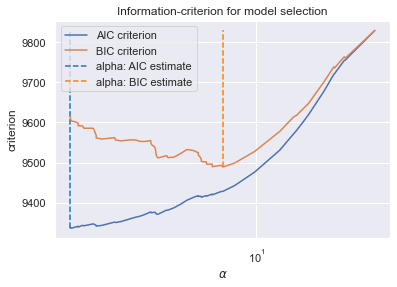

In [44]:
ax = results.plot()
ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection"
)

In [45]:
X_train2.shape

(800, 97)

In [46]:
X_train2.shape[1]/X_train2.shape[0]

0.12125

Let's choose the lambda of 7, based on BIC as p/N ratio suggests.

In [47]:
lasso_m1 = linear_model.Lasso(alpha=7)

lasso_m1.fit(X_train2, y_train2)
y_predtest_m1 = lasso_m1.predict(X_test2)
y_predtrain_m1 = lasso_m1.predict(X_train2)

print("IS R-squared of Lasso Model: ", round(r2_score(y_train2, y_predtrain_m1),4))
print("OOS R-squared of Lasso Model: ", round(r2_score(y_test2, y_predtest_m1),4))

IS R-squared of Lasso Model:  0.3143
OOS R-squared of Lasso Model:  0.213


The lasso model is not an overfit like the benchmark linear model. In-sample R2 is 31% and out of sample R2 is 21%.

In [48]:
lasso_m1.coef_

array([ -0.        ,   0.        ,  -0.        ,  24.38566986,
         0.        ,  -0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   1.0884183 ,
         0.        ,   0.        ,  -0.        ,   0.        ,
         0.        ,   0.        ,  -0.        ,   0.        ,
         0.        ,   0.        ,   3.13216685,   0.        ,
         0.        ,  10.57124471, -10.66331863,  -0.        ,
        -0.        ,   0.        ,  -0.        ,   0.        ,
         2.93050866,   4.5253603 ,   0.        ,  -0.        ,
         0.        ,  -0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,  -4.47465657,  -0.        ,
         4.53293814,  -0.        ,   0.        ,  -0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        -0.        ,  -0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,  12.39354323,  -0.  

In [49]:
val = {'variables':X2.columns,'coeff':list(lasso_m1.coef_)}

In [50]:
var_df1 = pd.DataFrame(val)
var_df1 = var_df1[(var_df1['coeff']>0)]

In [51]:
var_df1.sort_values(by=['coeff'], ascending=False)

,variables,coeff
3,star_rating,24.385670
62,general_contractor,12.393543
82,campground,11.277207
25,lodging,10.571245
68,bicycle_store,8.642126
95,room_classification_Other,6.865986
44,liquor_store,4.532938
33,doctor,4.525360
22,bar,3.132167
32,health,2.930509


These are the variables Lasso regression found to be useful in predicting the hotel prices from the dataset.

## Random Forest

In [52]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators = 500, random_state = 1, oob_score = True)
rf.fit(X_train1,y_train1)

RandomForestRegressor(n_estimators=500, oob_score=True, random_state=1)

In [53]:
# CV - R-squared
cross_val_score(rf, X_train1, y_train1, cv=10, scoring='r2').mean()

0.4185054043280346

In [54]:
# Out of Sample R-squared
r2_score(y_test1, rf.predict(X_test1))

0.19206020606102303

Text(0.5, 0, 'Random Forest Feature Importance')

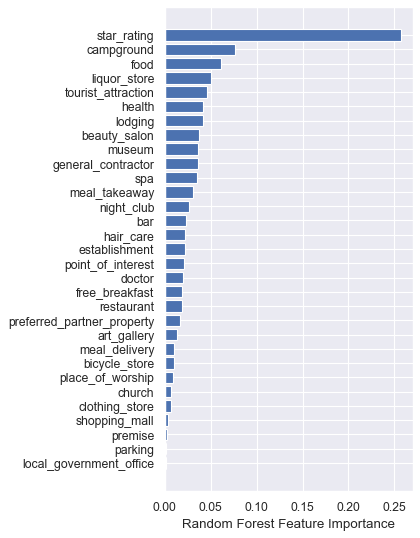

In [55]:
# Feature Importance
from matplotlib.pyplot import figure
figure(figsize=(4, 8), dpi=80)
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X1.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [56]:
val2 = {'variables':X1.columns[sorted_idx],'coeff':rf.feature_importances_[sorted_idx]}

var_df2 = pd.DataFrame(val2)
var_df2 = var_df2[(var_df2['coeff']>0)]

var_df2.sort_values(by=['coeff'], ascending=False)

,variables,coeff
30,star_rating,0.257270
29,campground,0.076121
28,food,0.061376
27,liquor_store,0.050068
26,tourist_attraction,0.045825
25,health,0.041498
24,lodging,0.041273
23,beauty_salon,0.037036
22,museum,0.036667
21,general_contractor,0.036189
